In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
!pip install cartopy rasterio rasterstats -q

In [ ]:
import ee
import geopandas as gpd
import pandas as pd
import geopandas as gpd
import numpy as np
import time
from rasterstats import zonal_stats
import rasterio
from osgeo import gdal
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import mapping
from rasterio.mask import mask
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor


In [ ]:
input_folder = '/content/drive/MyDrive/hwi_stats/dgca_back'

In [ ]:
df_wpp_prediction = pd.read_csv("/content/drive/MyDrive/CCRI/WPP2022_prediction.csv")
df_wpp_estimate = pd.read_csv("/content/drive/MyDrive/CCRI/WPP2022_estimate.csv")
df_wpp = pd.concat([df_wpp_estimate,df_wpp_prediction], ignore_index=True)
country_bnd = gpd.read_file('/content/drive/MyDrive/CCRI/global_bnd_adm0.geojson')

# Merge polygons with the same ISO3 code
country_bnd = country_bnd.dissolve(by='iso3')
country_bnd = country_bnd.reset_index()

In [ ]:
def hwi_summary(iso3, file_T, year, output_dir, df_wpp, country_bnd):
    """Calculates heatwave summary statistics for a given country and year."""

    # Check if population data exists (assuming df_wpp is your population DataFrame)
    child_percent = df_wpp.loc[
        (df_wpp['ISO3 Alpha-code'] == iso3) & (df_wpp['Year'] == year), '0-17'
    ]
    if child_percent.empty:
        print(f"No population data for {iso3} in {year}")
        return None

    # Filter and get the GeoDataFrame for the specified country
    filtered_gdf = country_bnd[country_bnd['iso3'] == iso3]

    # Create a temporary filtered GeoJSON file
    filtered_geojson_path = os.path.join(output_dir, f"{iso3}_filtered.geojson")
    filtered_gdf.to_file(filtered_geojson_path, driver='GeoJSON')

    # Output path for the clipped raster
    subset_T_path = os.path.join(output_dir, f"{iso3}_T_subset.tif")

    land_mask_file = '/content/drive/MyDrive/hwi_product/hwi_1970s/temp.vrt'
    subset_mask_path = os.path.join(output_dir, f"{iso3}_mask_subset.vrt")


    # Clip the main raster file
    try:
        warp_options_T = gdal.WarpOptions(
            cutlineDSName=filtered_geojson_path,
            cropToCutline=True,
            dstAlpha=True,  # Include transparency band if the source has it
            format='GTiff',
            creationOptions=["COMPRESS=LZW"],  # Optional compression
        )
        gdal.Warp(subset_T_path, file_T, options=warp_options_T)
        # print(f"Clipped main raster saved to {subset_T_path}")
    except Exception as e:
        print(f"Error clipping main raster: {e}")
        os.remove(filtered_geojson_path)
        return None  # Return early if clipping fails

    # Clip the land mask raster and use only the first band
    try:
        warp_options_mask = gdal.WarpOptions(
            cutlineDSName=filtered_geojson_path,
            dstAlpha=True,  # Include transparency band if the source has it
            cropToCutline=True,
            format='vrt'
        )
        gdal.Warp(subset_mask_path, land_mask_file, options=warp_options_mask)
        # print(f"Clipped land mask raster saved to {subset_mask_path}")
    except Exception as e:
        print(f"Error clipping land mask raster: {e}")
        os.remove(filtered_geojson_path)
        return None  # Return early if clipping fails

    # Read raster data
    data_T = {}

    try:
      with rasterio.open(subset_mask_path) as src:
          land_mask = src.read(1)
          land_mask_nan = np.where(land_mask != 1, np.nan, 1)
    except Exception as e:
        print(f"Error reading {subset_mask_path} for {iso3}: {e}")
        os.remove(filtered_geojson_path)
        return None # Return early if reading fails

    try:
        with rasterio.open(subset_T_path) as src:
            hw_count = src.read(1)
            hw_days = src.read(2)

            # Calculate days per heatwave count, handling potential zero division
            with np.errstate(divide='ignore', invalid='ignore'):
                hw_days_per_count = np.where(hw_count == 0, 0, hw_days / hw_count)

            data_T['hw_count'] = hw_count* land_mask_nan
            data_T['hw_days'] = hw_days_per_count* land_mask_nan
            data_T['hw_temp_diff'] = src.read(3)* land_mask_nan
            data_T['high_temp_degree_days'] = src.read(4)* land_mask_nan

    except Exception as e:
        print(f"Error reading {subset_T_path} for {iso3}: {e}")
        return None # Return early if reading fails

    # Calculate summary statistics
    results = {'iso3': iso3}

    for key in data_T.keys():
        values = data_T[key]
        # Check if all values are NaN
        if np.all(np.isnan(values)):
            results[f"{key}_{year}s"] = np.nan  # Assign NaN if all are NaN
        else:
            results[f"{key}_{year}s"] = np.nanmean(values)  # Use nanmean otherwise

    #Clean up temporary files
    for path in [subset_mask_path, subset_T_path, filtered_geojson_path]:
        try:
            os.remove(path)
        except Exception as e:  # Log the error but don't stop execution
            print(f"Error removing {path}: {e}")

    return results


In [ ]:


# Create the output directory if it doesn't exist
output_dir = "/content/drive/MyDrive/POP_stat/avg_country"
os.makedirs(output_dir, exist_ok=True)

for year in range(1960, 2030, 10):
  print (year)
  file_T = f"/content/drive/MyDrive/hwi_stats/dgca_back/average_hwi_{year}s.tif"

  results_list = []
  iso3_codes = country_bnd['iso3'].unique()

  with ThreadPoolExecutor(max_workers=10) as executor:
      futures = {executor.submit(hwi_summary, iso3, file_T, year, output_dir, df_wpp, country_bnd): iso3 for iso3 in iso3_codes}
      for future in futures:
          result = future.result()
          if result is not None:
              results_list.append(result)

  # Combine results and write to a single CSV
  all_results_df = pd.DataFrame(results_list)
  all_results_df.to_csv(os.path.join(output_dir, f"hwi_mean_country_{year}s.csv"), index=False)

In [ ]:
output_dir = "/content/drive/MyDrive/POP_stat/avg_country"
df_all = pd.read_csv(os.path.join(output_dir, f"hwi_mean_country_1960s.csv"))
df_all.set_index('iso3', inplace=True)

for year in range(1970, 2030, 10):
  df = pd.read_csv(os.path.join(output_dir, f"hwi_mean_country_{year}s.csv"))
  df.set_index('iso3', inplace=True)
  df_all = df_all.join(df, how='outer')

df_all.to_csv(os.path.join(output_dir, f"hwi_mean_country.csv"), index=True)

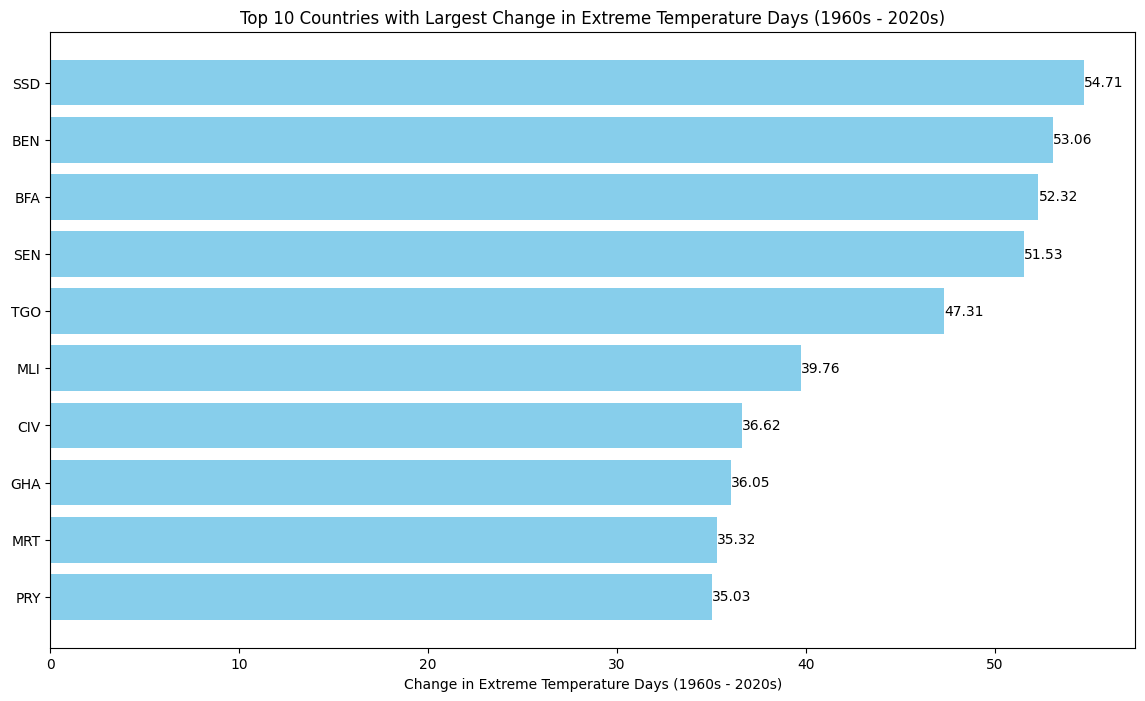

In [ ]:
import matplotlib.pyplot as plt

df = df_all.reset_index()

# Calculate the change in high_temp_degree_days between 1960s and 2020s
df['high_temp_degree_days_change'] = df['high_temp_degree_days_2020s'] - df['high_temp_degree_days_1960s']

# Get the top 10 countries with the largest change
top_10_countries = df.nlargest(10, 'high_temp_degree_days_change')

# Plotting with country names indicated
plt.figure(figsize=(14, 8))
bars = plt.barh(top_10_countries['iso3'], top_10_countries['high_temp_degree_days_change'], color='skyblue')
plt.xlabel('Change in Extreme Temperature Days (1960s - 2020s)')
plt.title('Top 10 Countries with Largest Change in Extreme Temperature Days (1960s - 2020s)')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest value on top

# Annotate country names
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left',
             color='black', fontsize=10)

plt.show()


<ipython-input-28-c8d71586bc0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wealthy_countries['high_temp_degree_days_change'] = df_wealthy_countries['high_temp_degree_days_2020s'] - df_wealthy_countries['high_temp_degree_days_1960s']


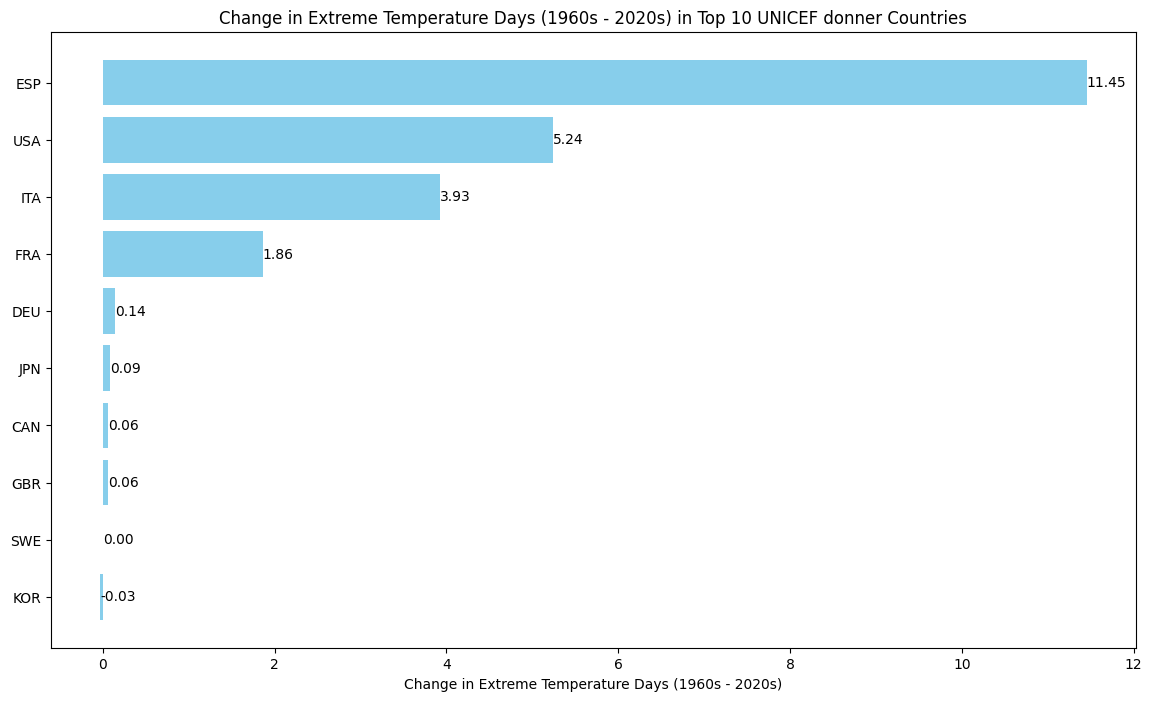

In [ ]:
import pandas as pd

# List of the 10 most wealthy countries by GDP (ISO3 codes)
wealthy_countries = ["USA", "SWE", "JPN", "DEU", "ESP", "GBR", "FRA", "ITA", "CAN", "KOR"]

# Filter the DataFrame for these wealthy countries
df_wealthy_countries = df[df['iso3'].isin(wealthy_countries)]

# Calculate the change in high_temp_degree_days between 1960s and 2020s
df_wealthy_countries['high_temp_degree_days_change'] = df_wealthy_countries['high_temp_degree_days_2020s'] - df_wealthy_countries['high_temp_degree_days_1960s']

# Get the top 10 countries with the largest change
top_10_countries = df_wealthy_countries.nlargest(10, 'high_temp_degree_days_change')

# Plotting with country names indicated
plt.figure(figsize=(14, 8))
bars = plt.barh(top_10_countries['iso3'], top_10_countries['high_temp_degree_days_change'], color='skyblue')
plt.xlabel('Change in Extreme Temperature Days (1960s - 2020s)')
plt.title('Change in Extreme Temperature Days (1960s - 2020s) in Top 10 UNICEF donner Countries')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest value on top

# Annotate country names
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left',
             color='black', fontsize=10)

plt.show()

